In [36]:
import pandas as pd

# Load the datasets
customers_file = "Customers.csv"
transactions_file = "Transactions.csv"
products_file = "Products.csv"

# Read the data into pandas DataFrames
customers_df = pd.read_csv(customers_file)
transactions_df = pd.read_csv(transactions_file)
products_df = pd.read_csv(products_file)

# Display the first few rows of each dataset
customers_df_head = customers_df.head()
transactions_df_head = transactions_df.head()
products_df_head = products_df.head()

customers_df_info = customers_df.info()
transactions_df_info = transactions_df.info()
products_df_info = products_df.info()

customers_df_head, transactions_df_head, products_df_head, customers_df_info, transactions_df_info, products_df_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
<class 'pandas.core.fr

(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Catego

In [37]:
# Merge datasets to prepare for clustering
# Merge Transactions with Customers to get customer details for each transaction
transactions_customers_df = transactions_df.merge(customers_df, on="CustomerID", how="inner")

# Merge the above with Products to get product details for each transaction
merged_df = transactions_customers_df.merge(products_df, on="ProductID", how="inner")

# Display the first few rows of the merged dataset and its structure
merged_df_head = merged_df.head()
merged_df_info = merged_df.info()

merged_df_head, merged_df_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
 10  ProductName      1000 non-null   object 
 11  Category         1000 non-null   object 
 12  Price_y          1000 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB


(  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue  Price_x     CustomerName         Region  SignupDate  \
 0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
 1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
 2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
 3      601.36   300.68  Travis Campbell  South America  2024-04-11   
 4      902.04   300.68    Timothy Perez         Europe  2022-03-15   
 
                        ProductName     Category  Price_y  
 0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
 1  ComfortLiving 

In [38]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Aggregate data at the customer level
customer_data = merged_df.groupby("CustomerID").agg(
    TotalTransactions=("TransactionID", "count"),
    TotalQuantity=("Quantity", "sum"),
    TotalSpend=("TotalValue", "sum"),
    AvgTransactionValue=("TotalValue", "mean"),
    Region=("Region", "first"),  # Retain the first region for each customer
    SignupDate=("SignupDate", "first")  # Retain the first signup date
).reset_index()

# Convert SignupDate to a numerical feature (days since signup)
customer_data["SignupDate"] = pd.to_datetime(customer_data["SignupDate"])
reference_date = pd.to_datetime("2025-01-01")  # Set a reference date
customer_data["DaysSinceSignup"] = (reference_date - customer_data["SignupDate"]).dt.days

# Drop the original SignupDate column
customer_data = customer_data.drop(columns=["SignupDate"])

# Encode categorical features and scale numerical features
categorical_features = ["Region"]
numerical_features = ["TotalTransactions", "TotalQuantity", "TotalSpend", "AvgTransactionValue", "DaysSinceSignup"]

# Set up preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features)
    ]
)

# Apply preprocessing
customer_data_preprocessed = preprocessor.fit_transform(customer_data)

# Check the preprocessed data
customer_data_preprocessed.shape, customer_data.head()


((199, 9),
   CustomerID  TotalTransactions  TotalQuantity  TotalSpend  \
 0      C0001                  5             12     3354.52   
 1      C0002                  4             10     1862.74   
 2      C0003                  4             14     2725.38   
 3      C0004                  8             23     5354.88   
 4      C0005                  3              7     2034.24   
 
    AvgTransactionValue         Region  DaysSinceSignup  
 0              670.904  South America              906  
 1              465.685           Asia             1053  
 2              681.345  South America              300  
 3              669.360  South America              815  
 4              678.080           Asia              870  )

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Initialize variables to store clustering results
best_db_index = float("inf")
best_k = None
best_model = None

# Test different numbers of clusters (2 to 10)
db_indices = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(customer_data_preprocessed)

    # Calculate the Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_data_preprocessed, cluster_labels)
    db_indices.append(db_index)

    # Track the best DB Index
    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
        best_model = kmeans

best_k, best_db_index


(7, 1.3182119134955388)

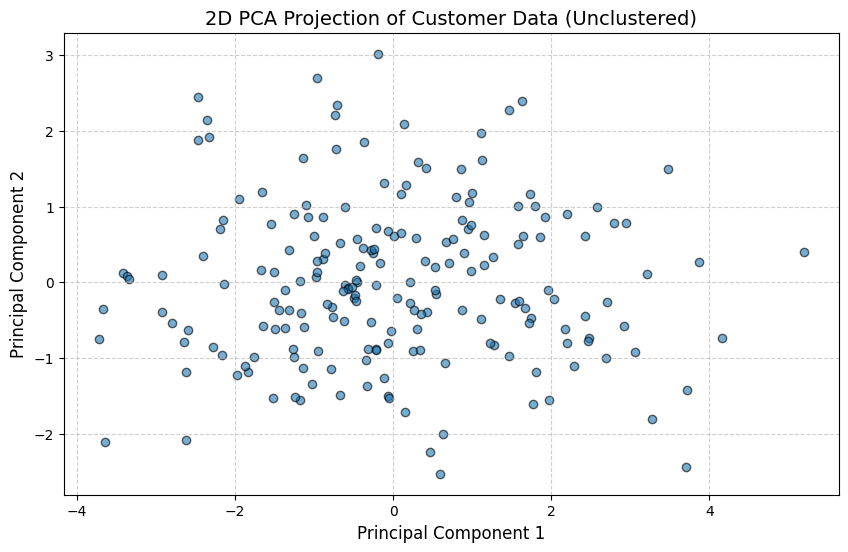

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_data_preprocessed)

# Plot the data without clustering labels (raw distribution)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.6, edgecolor='k')
plt.title("2D PCA Projection of Customer Data (Unclustered)", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
